# Temperature and Dephasing
Maverick Millican - (10.27.2022)

### Figuring out H5

In [53]:
import typing
import math
from uncertainties import ufloat
import numpy as np
from scipy.optimize import curve_fit
# from uncertainties import ufloat


def frequency_scan_model(frequency, freq_0, rabi_rate, amplitude):
    Omega = 2*np.pi * rabi_rate
    delta = 2*np.pi * (frequency - freq_0)
    def sinc(x):
        return np.sin(x)/x
    return np.pi**2/4 * sinc(np.sqrt(Omega**2 + delta**2)*np.pi / (2 * Omega))**2 * amplitude


def fit_frequency_scan(x_data: typing.List[float], y_data: typing.List[float], amplitude_guess: float = None,
                  rabi_rate_guess: float = None, freq_centre_guess: float = None, verbose: bool = True):

    if amplitude_guess is None:
        amplitude_guess = 1.0

    if rabi_rate_guess is None:
        rabi_rate_guesses = np.linspace(x_data[1] - x_data[0], x_data[-1] - x_data[0],  10)
    else:
        rabi_rate_guesses = [rabi_rate_guess]

    if freq_centre_guess is None:
        freq_centre_guesses = np.linspace(x_data[0], x_data[-1], 10)
    else:
        freq_centre_guesses = [freq_centre_guess]

    starting_guesses = np.array(np.meshgrid(rabi_rate_guesses, freq_centre_guesses)).T.reshape(-1, 2)

    best_fit_params = []
    best_fit_errors = []
    min_detuning_error = 1e6

    for [rabi_rate_guess, freq_centre_guess] in starting_guesses:
        try:
            popt, pcov = curve_fit(frequency_scan_model, x_data, y_data, p0=[freq_centre_guess, rabi_rate_guess, amplitude_guess],
                                   bounds=[[x_data[0]*0.9, 1e2, 0], [x_data[-1] * .9, 1e6, 1]])
            perr = np.sqrt(np.diag(pcov))
            detuning_error = perr[0]
            if detuning_error < min_detuning_error:
                min_detuning_error = detuning_error
                best_fit_params = popt
                best_fit_errors = perr
        except RuntimeError:
            pass

    if len(best_fit_params) == 0:
        print('Scipy optimization failed to find optimal parameters.')
        return [], []

    if verbose:
        print('Optimal parameters from curve_fit: ')
        print('Centre frequency : {:.1f} Hz'.format(ufloat(best_fit_params[0], best_fit_errors[0])))
        print('Rabi rate : {:3f} kHz'.format(ufloat(best_fit_params[1], best_fit_errors[1])/1e3))
        print('Amplitude : {:.3f}'.format(ufloat(best_fit_params[2], best_fit_errors[1])))

    return best_fit_params, best_fit_errors


def sin_func(x, amp, offset, freq, phase):
    return amp * np.sin(freq * x + phase) + offset

def fit_func(t, nbar, Omega):

    def prob_n(nbar, n):
        if n == 0:
            fact = 1
        else:
            fact =math.factorial(n)

        return np.exp(-1/2 * nbar) * (np.sqrt(nbar)**n) / np.sqrt(float(fact)) #* np.sum([(np.sqrt(nbar))**n/np.sqrt(np.math.factorial(n)) for n in range(50)])

    def Omega_n(n):
        return np.sqrt(n+1) * Omega

    gamma = 1

    prob = 0
    for n in range(100):
        prob += prob_n(nbar, n) / 2 * (1 - np.exp(-gamma * t) * np.cos(Omega_n(n) * t))

    return prob / (nbar + 1)

def exp_fit(t, rate, scale):
    return np.exp(-rate * t) * scale

sine fit [-4.28083226e-01  4.93968787e-01  1.55717097e+04  1.42466360e+00]
curve_fit [1.00574679e-11 1.55276743e+04]
curve covariance [1.95511811e-12 4.41317665e+01]


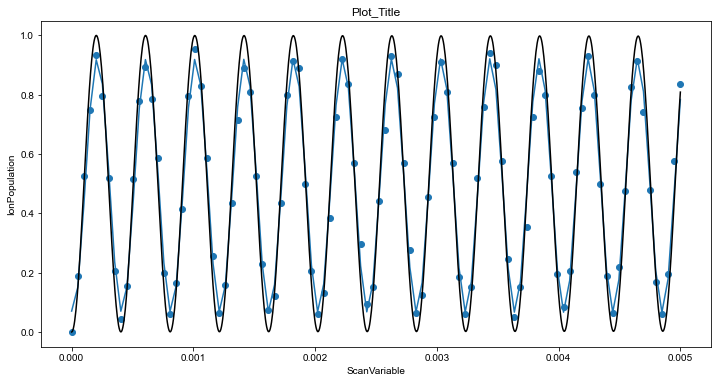

In [2]:
import h5py
import sys
import matplotlib
import numpy as np
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams['font.size'] = '14'
import matplotlib.pyplot as plt
# from Frequency_Scan.py import *

"""
Arj
7/3/22

USE
---

This script simply plots a matplotlib version of results for quick access of a h5 file from ARTIQ results.
The script takes 2 arguments and won't work unless you supply them

in the cmd line, move to this directory and perform the following
> python result_reader.py [filename] [plot_title]


"""
fileName = '000027073-RamanDdsApdBsbTimeScan.h5'


f = h5py.File(fileName,'r')
#Get the HDF5 group
group = f['datasets']
population = f['datasets/plot.1d_scan.histogram_context.probability']
P1 = np.transpose(population[()])[0]
time = f['datasets/scan/duration']
time = time[()]
f.close()
# print(time)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.scatter(time, P1)
plot_title = 'Plot_Title'
ax.set_xlabel('ScanVariable')
ax.set_ylabel('IonPopulation')
ax.set_title(str(plot_title))

popt, pcov = curve_fit(sin_func, time, P1, p0=[1, .5, 13*2*np.pi /.005, 0], maxfev=10000)
x = np.linspace(0, .005, 100)
y = sin_func(x, *popt)
ax.plot(x, y)
print(f'sine fit {popt}')
lower, upper = abs(popt[2]*.9), abs(popt[2]*1.1)

popt, pcov = curve_fit(fit_func, time, P1, p0=[1, popt[2]], bounds=((0,0), (np.inf, np.inf)), maxfev=1000)
x = np.linspace(0, .005, 1000)
y = fit_func(x, *popt)
ax.plot(x, y, 'k')
print(f'curve_fit {popt}')
print(f'curve covariance {np.diag(pcov)}')

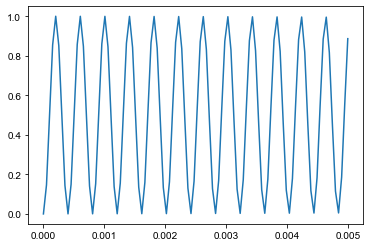

In [3]:
plt.plot(time, fit_func(time, 1.00574679e-11, 1.55717097e+04))

In [4]:
f = h5py.File('000027073-RamanDdsApdBsbTimeScan.h5', 'r')

exp_probs = (np.transpose(f['datasets/plot.1d_scan.histogram_context.probability'][:])[0] )
exp_times = f['datasets/scan/duration'][:]
exp_probs


array([0.   , 0.19 , 0.525, 0.75 , 0.935, 0.795, 0.52 , 0.205, 0.045,
       0.155, 0.515, 0.78 , 0.895, 0.785, 0.585, 0.2  , 0.06 , 0.165,
       0.415, 0.795, 0.955, 0.83 , 0.585, 0.255, 0.065, 0.16 , 0.435,
       0.715, 0.89 , 0.81 , 0.525, 0.23 , 0.075, 0.12 , 0.435, 0.8  ,
       0.915, 0.89 , 0.5  , 0.205, 0.06 , 0.13 , 0.385, 0.725, 0.92 ,
       0.835, 0.57 , 0.295, 0.095, 0.15 , 0.44 , 0.68 , 0.93 , 0.87 ,
       0.57 , 0.275, 0.065, 0.125, 0.455, 0.725, 0.91 , 0.81 , 0.57 ,
       0.185, 0.06 , 0.15 , 0.52 , 0.76 , 0.94 , 0.9  , 0.575, 0.245,
       0.05 , 0.15 , 0.355, 0.725, 0.88 , 0.8  , 0.525, 0.195, 0.085,
       0.205, 0.54 , 0.755, 0.93 , 0.8  , 0.5  , 0.19 , 0.065, 0.22 ,
       0.475, 0.825, 0.915, 0.74 , 0.48 , 0.17 , 0.06 , 0.195, 0.575,
       0.835])

In [5]:
f.keys()

<KeysViewHDF5 ['archive', 'artiq_version', 'datasets', 'expid', 'rid', 'run_time', 'start_time']>

In [6]:
# f['archive'].keys()
# f['artiq_version']
f['datasets'].keys()
# f['expid']
# f['rid']
# f['run_time']
# f['start_time']

<KeysViewHDF5 ['dax', 'histogram_context', 'plot.1d_scan.histogram_context.fit', 'plot.1d_scan.histogram_context.probability', 'scan']>

In [7]:
print(f['datasets'].keys())
# print(f['datasets']['plot.1d_scan.histogram_context.probability'][:])


<KeysViewHDF5 ['dax', 'histogram_context', 'plot.1d_scan.histogram_context.fit', 'plot.1d_scan.histogram_context.probability', 'scan']>


In [8]:
f['datasets']['dax']['dax_version'][()]

b'6.10'

sine fit [-4.28083226e-01  4.93968787e-01  1.55717097e+04  1.42466360e+00]
curve_fit [1.00574679e-11 1.55276743e+04]
curve covariance [1.95511811e-12 4.41317665e+01]


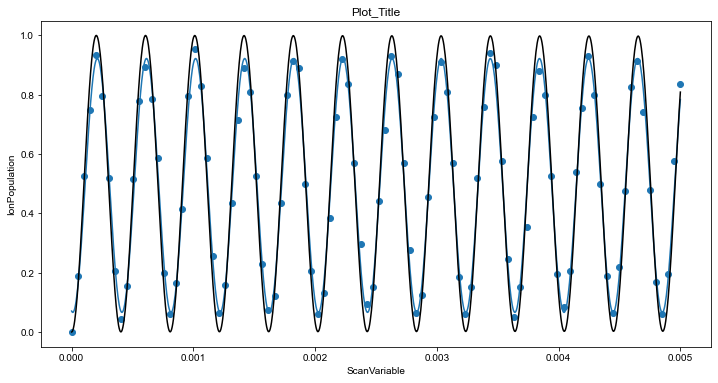

In [9]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.scatter(exp_times, exp_probs)
ax.set_xlabel('ScanVariable')
ax.set_ylabel('IonPopulation')
ax.set_title(str(plot_title))

popt, pcov = curve_fit(sin_func, time, P1, p0=[1, .5, 13*2*np.pi /.005, 0], maxfev=10000)
x = np.linspace(0, .005, 1000)
y = sin_func(x, *popt)
ax.plot(x, y)
print(f'sine fit {popt}')
lower, upper = abs(popt[2]*.9), abs(popt[2]*1.1)

popt, pcov = curve_fit(fit_func, time, P1, p0=[1, popt[2]], bounds=((0,0), (np.inf, np.inf)), maxfev=1000)
x = np.linspace(0, .005, 1000)
y = fit_func(x, *popt)
ax.plot(x, y, 'k')
print(f'curve_fit {popt}')
print(f'curve covariance {np.diag(pcov)}')

## Rabi Flopping Method

sine fit [-4.28083226e-01  4.93968787e-01  1.55717097e+04  1.42466360e+00]
curve_fit [3.30998395e-13 1.55276743e+04]
curve covariance [1.87370647e-12 4.41317146e+01]


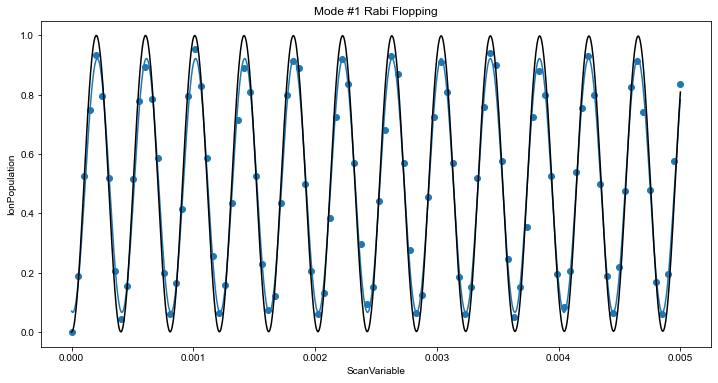

In [10]:
fileName = '000027073-RamanDdsApdBsbTimeScan.h5'


f = h5py.File(fileName,'r')
#Get the HDF5 group
group = f['datasets']
population = f['datasets/plot.1d_scan.histogram_context.probability']
P1 = np.transpose(population[()])[0]
time = f['datasets/scan/duration']
time = time[()]
f.close()
# print(time)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.scatter(time, P1)
plot_title = 'Mode #1 Rabi Flopping'
ax.set_xlabel('ScanVariable')
ax.set_ylabel('IonPopulation')
ax.set_title(str(plot_title))

popt, pcov = curve_fit(sin_func, time, P1, p0=[1, .5, 13*2*np.pi /.005, 0], maxfev=10000)
x = np.linspace(0, .005, 1000)
y = sin_func(x, *popt)
ax.plot(x, y)
print(f'sine fit {popt}')
lower, upper = abs(popt[2]*.9), abs(popt[2]*1.1)

popt, pcov = curve_fit(fit_func, time, P1, p0=[.037, popt[2]], bounds=((0,0), (np.inf, np.inf)), maxfev=1000)
x = np.linspace(0, .005, 1000)
y = fit_func(x, *popt)
ax.plot(x, y, 'k')
print(f'curve_fit {popt}')
print(f'curve covariance {np.diag(pcov)}')

sine fit [-4.30892318e-01  4.92942650e-01  1.37492566e+04  1.42609065e+00]
curve_fit [1.00000000e-03 1.37057691e+04]
curve covariance [5.85361138e-07 4.85811698e+01]


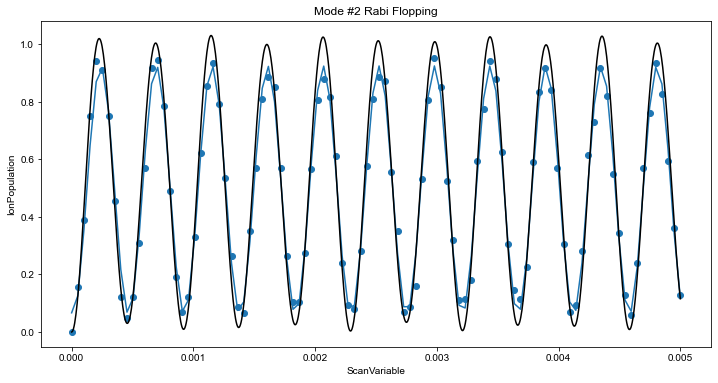

In [11]:
fileName = '000027074-RamanDdsApdBsbTimeScan.h5'


f = h5py.File(fileName,'r')
#Get the HDF5 group
group = f['datasets']
population = f['datasets/plot.1d_scan.histogram_context.probability']
P1 = np.transpose(population[()])[0]
time = f['datasets/scan/duration']
time = time[()]
f.close()
# print(time)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.scatter(time, P1)
plot_title = 'Mode #2 Rabi Flopping'
ax.set_xlabel('ScanVariable')
ax.set_ylabel('IonPopulation')
ax.set_title(str(plot_title))

popt, pcov = curve_fit(sin_func, time, P1, p0=[1, .5, 11*2*np.pi /.005, 0], maxfev=10000)
x = np.linspace(0, .005, 100)
y = sin_func(x, *popt)
ax.plot(x, y)
print(f'sine fit {popt}')
lower, upper = abs(popt[2]*.9), abs(popt[2]*1.1)

popt, pcov = curve_fit(fit_func, time, P1, p0=[.042, popt[2]], bounds=((.001,0), (np.inf, np.inf)), maxfev=1000)
x = np.linspace(0, .005, 1000)
y = fit_func(x, *popt)
ax.plot(x, y, 'k')
print(f'curve_fit {popt}')
print(f'curve covariance {np.diag(pcov)}')

## Sideband Thermometry Method

Optimal parameters from curve_fit: 
Centre frequency : 585.9+/-1387.1 Hz
Rabi rate :  16+/-  4 kHz
Amplitude : 0.034+/-3985.274
[5.85876976e+02 1.60243085e+04 3.37835549e-02]


(0.0, 1.0)

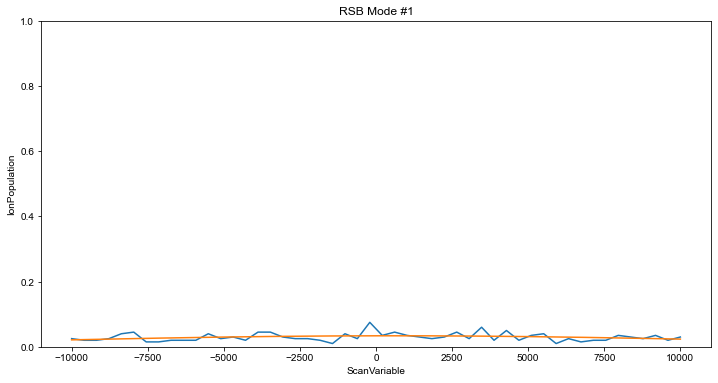

In [40]:
fileName = '000027077-RamanDdsApdRsbFreqScan.h5'


f = h5py.File(fileName,'r')
#Get the HDF5 group
group = f['datasets']
population = f['datasets/plot.1d_scan.histogram_context.probability']
P1 = np.transpose(population[:])[0]
time = f['datasets/scan/detuning']
time = time[:]
f.close()
# print(time)

pi_time = 203.1e-6
rabi_rate = 1/(2*pi_time)


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(time, P1)
plot_title = 'RSB Mode #1'
ax.set_xlabel('ScanVariable')
ax.set_ylabel('IonPopulation')
ax.set_title(str(plot_title))

popt, pcov = fit_frequency_scan(time, P1, 0.06, rabi_rate, 0, True)
x = np.linspace(-10000, 10000, 1000)
y = frequency_scan_model(x, *popt)
plt.plot(x, y)
print(popt)
prob_rsb1 = popt[2]
plt.ylim(0,1)

Optimal parameters from curve_fit: 
Centre frequency : 566.5+/-533.7 Hz
Rabi rate : 10.3+/-1.0 kHz
Amplitude : 0.039+/-984.246
[5.66450845e+02 1.02969601e+04 3.85757878e-02]


(0.0, 1.0)

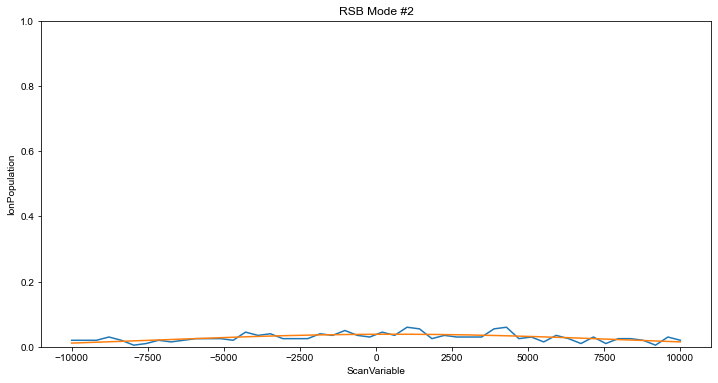

In [41]:
fileName = '000027078-RamanDdsApdRsbFreqScan.h5'


f = h5py.File(fileName,'r')
#Get the HDF5 group
group = f['datasets']
population = f['datasets/plot.1d_scan.histogram_context.probability']
P1 = np.transpose(population[()])[0]
time = f['datasets/scan/detuning']
time = time[()]
f.close()
# print(time)

pi_time = 228.4e-6
rabi_rate = 1/(2*pi_time)


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(time, P1)
plot_title = 'RSB Mode #2'
ax.set_xlabel('ScanVariable')
ax.set_ylabel('IonPopulation')
ax.set_title(str(plot_title))


popt, pcov = fit_frequency_scan(time, P1, 0.01, rabi_rate, 0, True)
x = np.linspace(-10000, 10000, 1000)
y = frequency_scan_model(x, *popt)
plt.plot(x, y)
print(popt)
prob_rsb2 = popt[2]
plt.ylim(0,1)

Optimal parameters from curve_fit: 
Centre frequency : -163.2+/-27.3 Hz
Rabi rate : 2.547+/-0.031 kHz
Amplitude : 0.941+/-30.733
[-1.63234062e+02  2.54686526e+03  9.40602446e-01]


(0.0, 1.0)

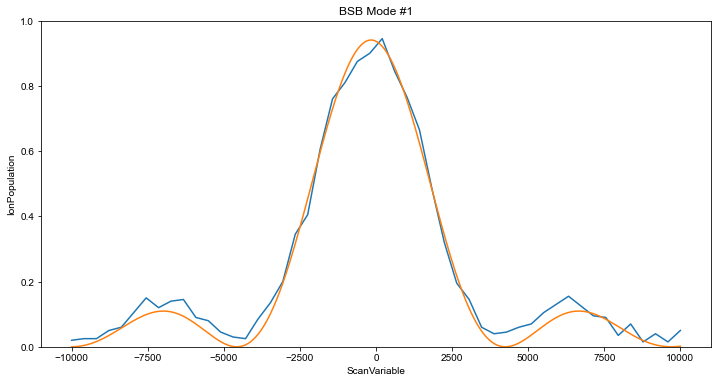

In [42]:
fileName = '000027079-RamanDdsApdBsbFreqScan.h5'


f = h5py.File(fileName,'r')
#Get the HDF5 group
group = f['datasets']
population = f['datasets/plot.1d_scan.histogram_context.probability']
P1 = np.transpose(population[()])[0]
time = f['datasets/scan/detuning']
time = time[()]
f.close()
# print(time)

pi_time = 202.3e-6
rabi_rate = 1/(2*pi_time)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(time, P1)
plot_title = 'BSB Mode #1'
ax.set_xlabel('ScanVariable')
ax.set_ylabel('IonPopulation')
ax.set_title(str(plot_title))


popt, pcov = fit_frequency_scan(time, P1, .8, rabi_rate, 0, True)
x = np.linspace(-10000, 10000, 1000)
y = frequency_scan_model(x, *popt)
ax.plot(x, y)
print(popt)
prob_bsb1 = popt[2]
plt.ylim(0,1)

Optimal parameters from curve_fit: 
Centre frequency : -212.5+/-22.7 Hz
Rabi rate : 2.197+/-0.025 kHz
Amplitude : 0.957+/-24.771
[-2.12491634e+02  2.19726140e+03  9.57040915e-01]


(0.0, 1.0)

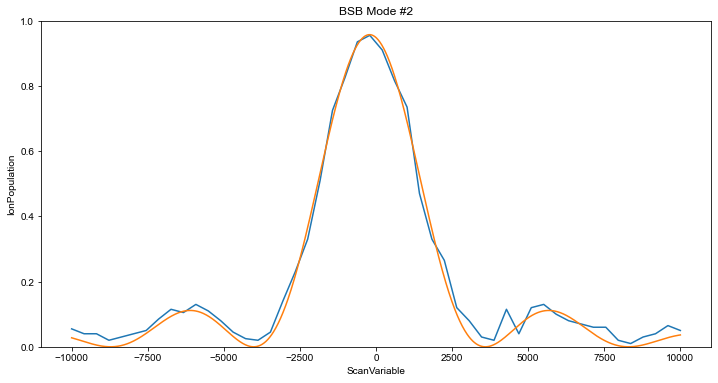

In [43]:
fileName = '000027080-RamanDdsApdBsbFreqScan.h5'


f = h5py.File(fileName,'r')
#Get the HDF5 group
group = f['datasets']
population = f['datasets/plot.1d_scan.histogram_context.probability']
P1 = np.transpose(population[()])[0]
time = f['datasets/scan/detuning']
time = time[()]
f.close()
# print(time)

pi_time = 229.2e-6
rabi_rate = 1/(2*pi_time)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(time, P1)
plot_title = 'BSB Mode #2'
ax.set_xlabel('ScanVariable')
ax.set_ylabel('IonPopulation')
ax.set_title(str(plot_title))


popt, pcov = fit_frequency_scan(time, P1, .8, rabi_rate, 0, True)
x = np.linspace(-10000, 10000, 1000)
y = frequency_scan_model(x, *popt)
ax.plot(x, y)
print(popt)
prob_bsb2 = popt[2]
plt.ylim(0,1)

In [17]:
mode1_rate = prob_rsb1/prob_bsb1
mode2_rate = prob_rsb2/prob_bsb2
nbar1 = mode1_rate / (1 - mode1_rate)
nbar2 = mode2_rate / (1 - mode2_rate)
print(nbar1)
print(nbar2)

0.060123269473641563
0.06416537193830511


## Dephasing Experiment (Ramsey)

In [19]:
fileName = '000027082-RamanDdsApdBsbRamseyCoherence.h5'


f = h5py.File(fileName,'r')
#Get the HDF5 group
group = f['datasets']
population = f['datasets/plot.1d_scan.histogram_context.probability']
P1 = population[()]
time = f['datasets/scan/detuning']
time = time[()]
f.close()
# print(time)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.plot(time, P1)
plot_title = 'BSB Mode #2'
ax.set_xlabel('ScanVariable')
ax.set_ylabel('IonPopulation')
ax.set_title(str(plot_title))

KeyError: "Unable to open object (object 'detuning' doesn't exist)"

In [ ]:
f = h5py.File(fileName,'r')

In [20]:
f['datasets/plot.1d_scan.histogram_context.probability'][:]

array([[0.11],
       [0.28],
       [0.32],
       [0.43],
       [0.62],
       [0.76],
       [0.79],
       [0.88],
       [0.93],
       [0.94],
       [0.88],
       [0.79],
       [0.58],
       [0.61],
       [0.4 ],
       [0.22],
       [0.19],
       [0.09],
       [0.11],
       [0.07],
       [0.19],
       [0.82],
       [0.95],
       [0.91],
       [0.84],
       [0.78],
       [0.63],
       [0.48],
       [0.28],
       [0.3 ],
       [0.26],
       [0.11],
       [0.04],
       [0.09],
       [0.2 ],
       [0.23],
       [0.29],
       [0.33],
       [0.35],
       [0.48],
       [0.66],
       [0.75],
       [0.75],
       [0.67],
       [0.68],
       [0.62],
       [0.47],
       [0.31],
       [0.13],
       [0.05],
       [0.08],
       [0.15],
       [0.11],
       [0.23],
       [0.33],
       [0.24],
       [0.34],
       [0.81],
       [0.82],
       [0.93],
       [0.92],
       [0.88],
       [0.88],
       [0.48],
       [0.38],
       [0.17],
       [0.

In [21]:
f['datasets/scan/product/ramsey_duration'][:]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00666667, 0.00666667, 0.00666667, 0.00666667,
       0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
       0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
       0.00666667, 0.00666667, 0.00666667, 0.00666667, 0.00666667,
       0.00666667, 0.00666667, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.01333333, 0.01333333,
       0.01333333, 0.01333333, 0.01333333, 0.02      , 0.02      ,
       0.02      , 0.02      , 0.02      , 0.02      , 0.02      ,
       0.02      , 0.02      , 0.02      , 0.02      , 0.02   

In [22]:
list(f['datasets'].keys())

['dax',
 'histogram_context',
 'plot.1d_scan.histogram_context.fit',
 'plot.1d_scan.histogram_context.probability',
 'scan']

In [23]:
import pandas as pd

In [24]:
it = pd.DataFrame()

In [25]:
it['phase'] = f['datasets/scan/product/phase'][:]
it['ramsey_duration'] = f['datasets/scan/product/ramsey_duration'][:]
it['probability'] = f['datasets/plot.1d_scan.histogram_context.probability'][:]

In [26]:
it

,phase,ramsey_duration,probability
0,0.00,0.00,0.11
1,0.05,0.00,0.28
2,0.10,0.00,0.32
3,0.15,0.00,0.43
4,0.20,0.00,0.62
...,...,...,...
205,0.80,0.06,0.54
206,0.85,0.06,0.61
207,0.90,0.06,0.63
208,0.95,0.06,0.76


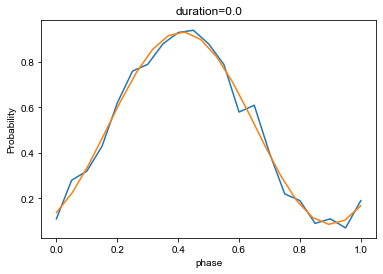

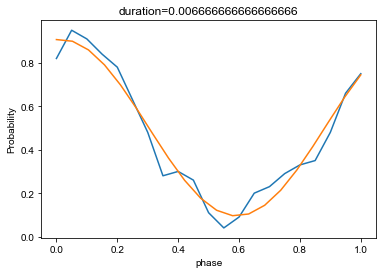

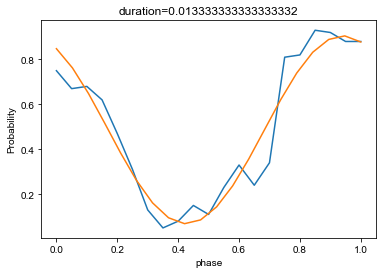

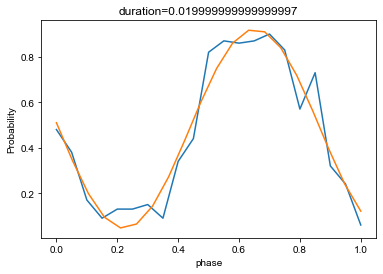

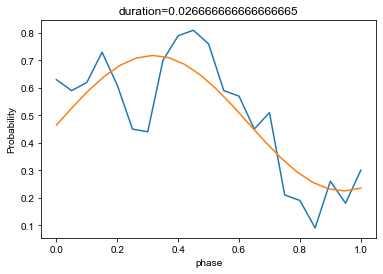

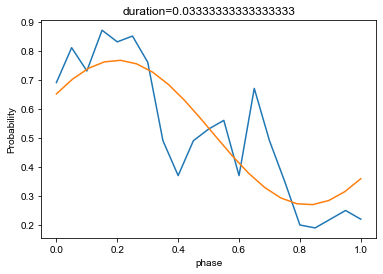

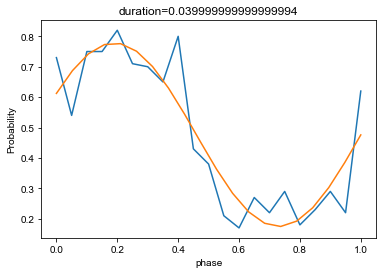

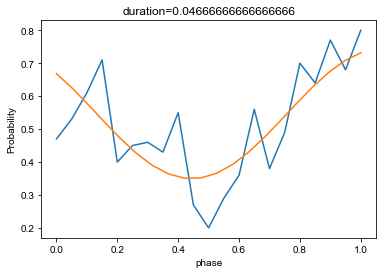

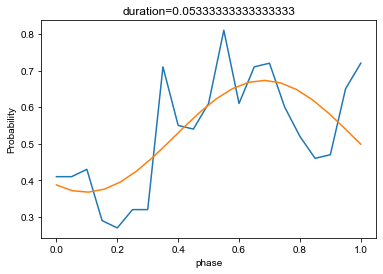

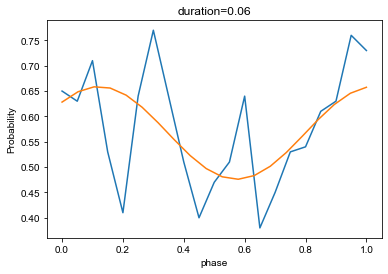

[0.8475273843989837, 0.8131579326445109, 0.8366372538944866, 0.8763100708527509, 0.49351629646702977, 0.4976424727319175, 0.6036048422619322, 0.39429518901287963, 0.30547115224478977, 0.1829992965302382]


In [27]:

amplitudes = []
phase_ref = f['datasets/scan/phase'][:]
duration_ref = f['datasets/scan/ramsey_duration'][:]
for i in duration_ref:
    use = it.query(f'ramsey_duration == {i}')
    plt.plot(use['phase'], use['probability'])
    plt.xlabel('phase')
    plt.ylabel('Probability')
    plt.title(f'duration={i}')
    popt, pcov = curve_fit(sin_func, use['phase'], use['probability'], p0=[.8, .5, 2*np.pi, np.pi], bounds= ((0, 0, 2*np.pi*.8, 0), (1, 1, 2*np.pi*1.2, 2*np.pi)), maxfev=10000)
    x = np.linspace(0, 1, 20)
    y = sin_func(x, *popt)
    plt.plot(x, y)
    amplitudes.append(abs(2*popt[0]))
    plt.show()
print(amplitudes)

C:\Users\mmil4812\AppData\Local\Temp/ipykernel_15828/1656653623.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(-rate * t) * scale


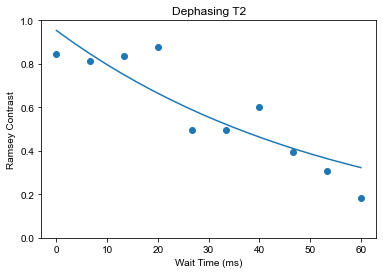

Rate = 0.018046+/-0.000014
T2 = 1/Rate = 55.41+/-0.04ms


In [54]:
plt.scatter(duration_ref*1000, amplitudes)

popt, pcov = curve_fit(exp_fit, duration_ref*1000, amplitudes, p0=[1,.8], maxfev=10000)
x = np.linspace(0, .06, 20)
y = exp_fit(x*1000, *popt)
plt.plot(x*1000, y)
plt.xlabel('Wait Time (ms)')
plt.ylabel('Ramsey Contrast')
plt.title('Dephasing T2')
plt.ylim(0,1)
plt.show()
rate = popt[0]
rate_error = pcov[0][0]
gamma = ufloat(rate, rate_error)
print(f'Rate = {gamma}')
print(f'T2 = 1/Rate = {1/gamma}ms')


In [46]:
popt[2]

2181.2391315101786